In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import layers, models, optimizers
from tensorflow import keras

import joblib

***

#### Exploratory Data Analysis & Data Pre-Processing

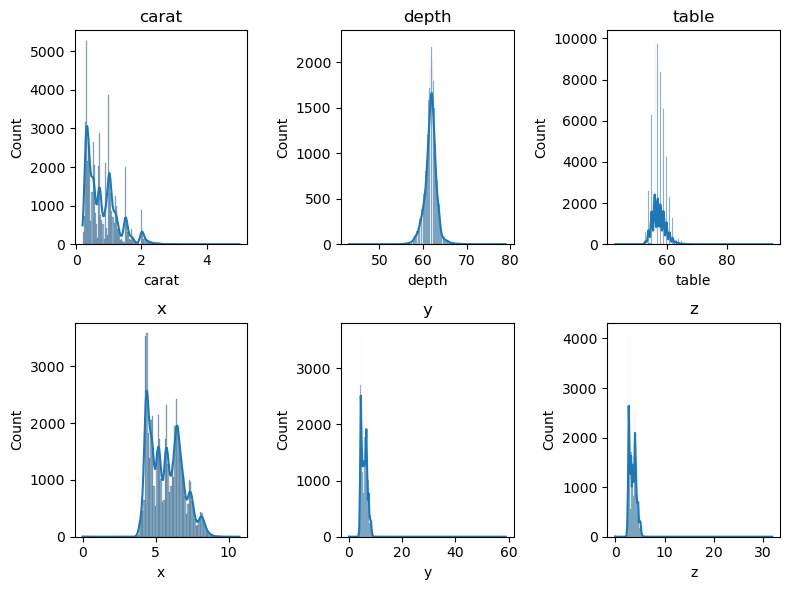


mean:
carat     0.797940
depth    61.749405
table    57.457184
x         5.731157
y         5.734526
z         3.538734
dtype: float64 , 
median:
carat     0.70
depth    61.80
table    57.00
x         5.70
y         5.71
z         3.53
dtype: float64 , 
std:
 carat    0.474011
depth    1.432621
table    2.234491
x        1.121761
y        1.142135
z        0.705699
dtype: float64


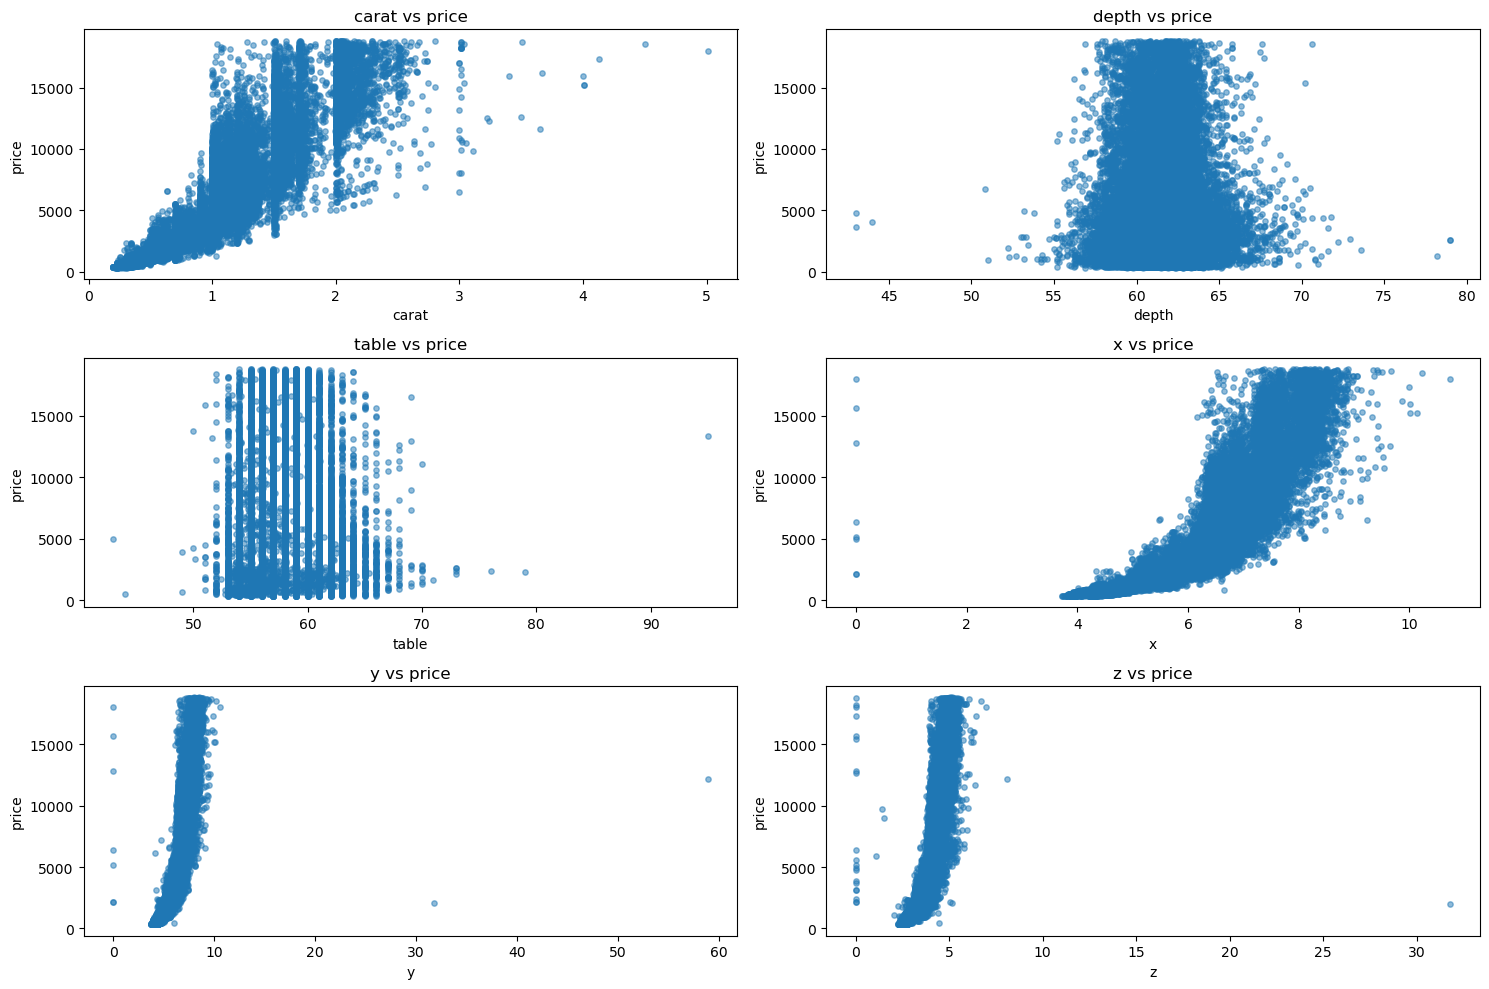

/var/folders/61/4f_9vd3x7c9_5dsr15qd4fww0000gn/T/ipykernel_80635/2300518303.py:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


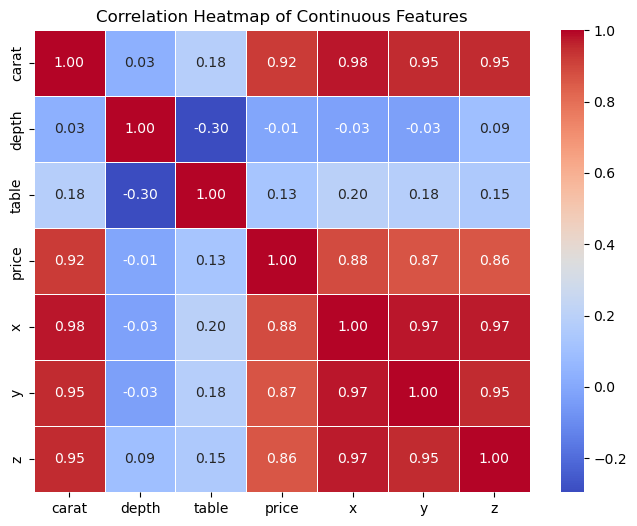

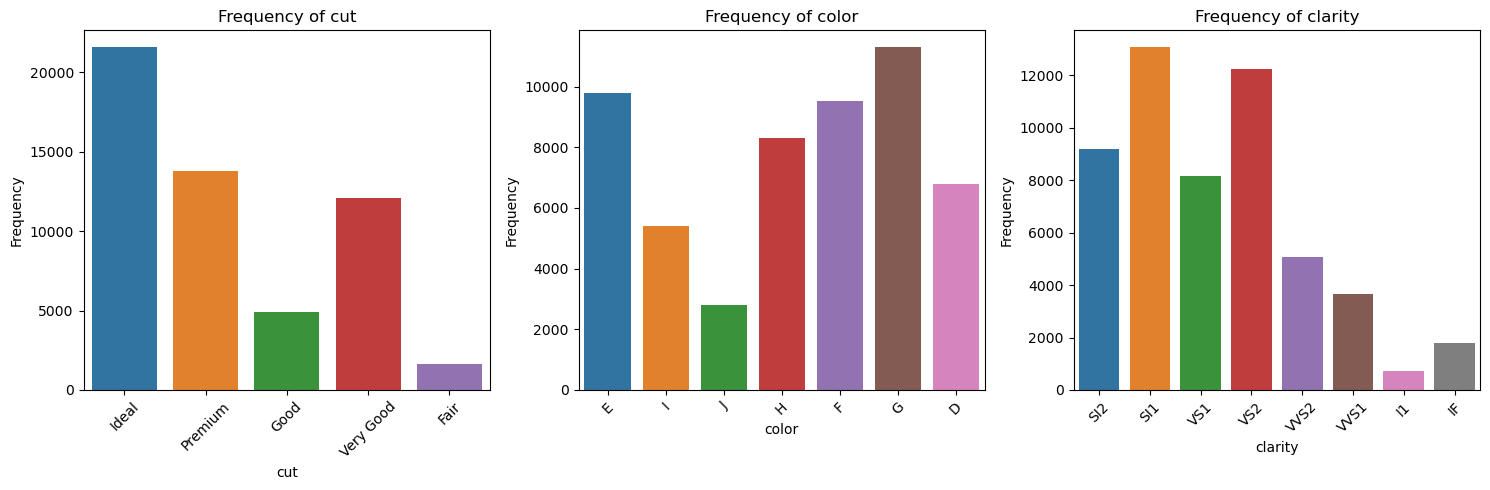

In [2]:
### Exploratory Data Analysis
### ---------------------------------------------------------------------------------
df = pd.read_csv("../dataset/diamonds.csv") 
df = df.iloc[:, 1:]  # remove index column          
# df.head()

### Plot distribution of continous features
features_to_plot = ['carat', 'depth', 'table', 'x','y','z']
plt.figure(figsize=(8, 6))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()
print("\nmean:\n{} , \nmedian:\n{} , \nstd:\n {}".format(df[features_to_plot].mean() , 
                                                         df[features_to_plot].median(), 
                                                         df[features_to_plot].std()))

### Plot scatterplot of continous features vs. price
feature_names = ['carat', 'depth', 'table', 'x','y','z']
y = df['price']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 2, i+1)
    plt.scatter(df[feature], y, alpha=0.5, s=15)  # s=20 sets the size of the points
    plt.title(f'{feature} vs price')
    plt.xlabel(feature)
    plt.ylabel('price')
plt.tight_layout()
plt.show()

### Correlation Matrix between continous predictors and Y
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

### Plot Frequency of categorical variables
categorical_vars = ["cut", "color", "clarity"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df, x=var, ax=axes[i])
    axes[i].set_title("Frequency of " + var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")
    axes[i].tick_params(axis='x', rotation=45)  
plt.tight_layout()
plt.show()

(53940, 9)
(51786, 9)


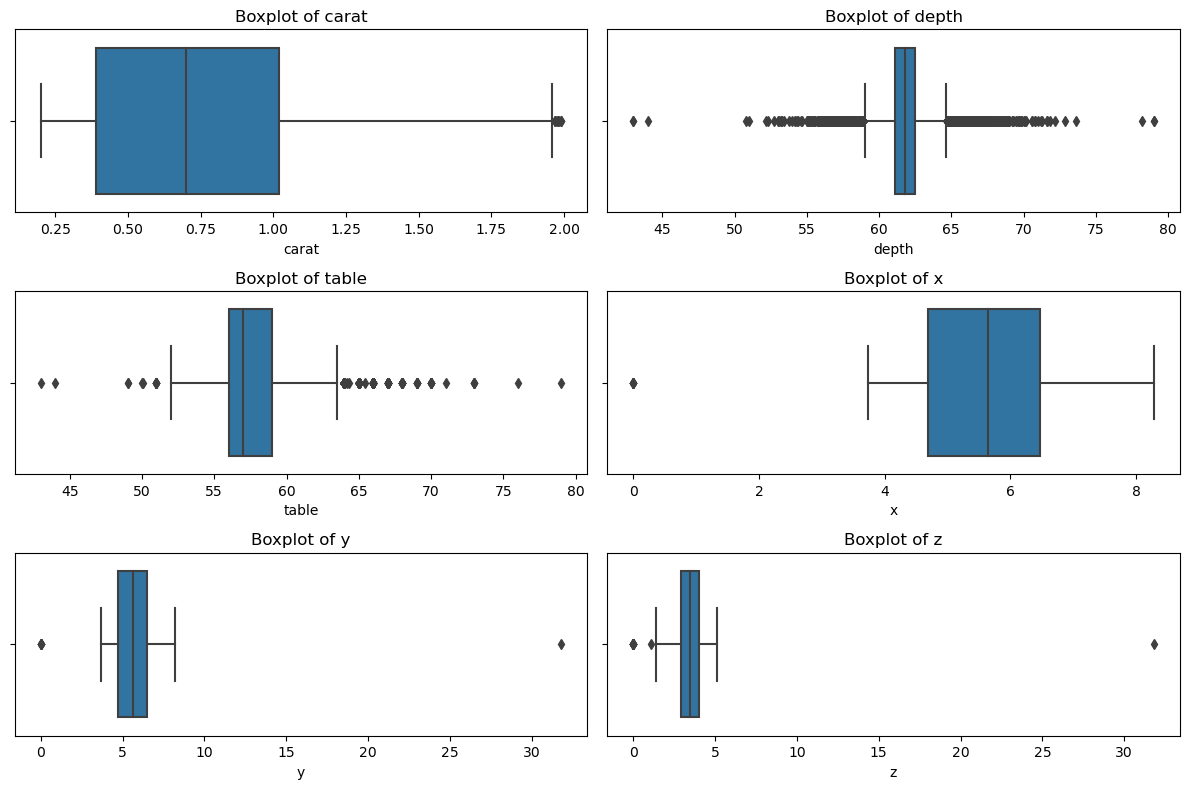

['scaler.joblib']

In [3]:
### Data Pre-Processing
### ----------------------------------------------------------------------------
#### Label encodings // Custom label encoding mappings
cut_mapping = {
    'Fair': 0,
    'Good': 1,
    'Very Good': 2,
    'Premium': 3,
    'Ideal': 4
}

color_mapping = {
    'J': 0,
    'I': 1,
    'H': 2,
    'G': 3,
    'F': 4,
    'E': 5,
    'D': 6
}

clarity_mapping = {
    'I1': 0,
    'SI2': 1,
    'SI1': 2,
    'VS2': 3,
    'VS1': 4,
    'VVS2': 5,
    'VVS1': 6,
    'IF': 7
}

# Apply the mappings to the dataset
df['cut_encoded'] = df['cut'].map(cut_mapping)
df['color_encoded'] = df['color'].map(color_mapping)
df['clarity_encoded'] = df['clarity'].map(clarity_mapping)
df = df.drop(['cut', 'color', 'clarity'], axis=1)
# df.head()

# creating X and y
y = df['price']
df.drop(columns=['price'], inplace=True)
X = df
print(X.shape)

### removing outliers from carat predictor
q1 = X['carat'].quantile(0.25)
q3 = X['carat'].quantile(0.75)
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr 
upper_bound = q3 + 1.5 * iqr
X_no_outlier = X[(X['carat'] > lower_bound) & (X['carat'] < upper_bound)]
y_no_outlier = y[(X['carat'] > lower_bound) & (X['carat'] < upper_bound)]
print(X_no_outlier.shape)

### boxplot 
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()
for i, feature in enumerate(features_to_plot):
    sns.boxplot(x=X_no_outlier[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

### split into test/train
X = X_no_outlier
y = y_no_outlier
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

### scaling using z-score transformation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
m,n = X_train.shape
joblib.dump(scaler, 'scaler.joblib')

***

#### Linear & Polyomial Regression

In [4]:
### Linear Regression
### ----------------------------------------------------------------------------

### Cross validation procedure
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

### Model accuracy on testing data
model = LinearRegression()
model.fit(X_train, y_train)
joblib.dump(model, 'linear_regression_model.joblib')
y_pred = model.predict(X_test)

mae = np.mean(abs(y_pred - y_test))
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print("R-squared:", r_squared)
print("Mean Squared Error:", mse)

Mean MSE: 1129207.421601696
Standard Deviation of MSE: 47218.772275043324
MAE: 718.8436939817379
R-squared: 0.8989296252585023
Mean Squared Error: 1110908.273136779


Mean MAE: 2576.452525421906
Standard Deviation of MAE: 27.98451088034564
Mean MAE: 719.0618804934683
Standard Deviation of MAE: 14.645906080255836
Mean MAE: 405.1943866419048
Standard Deviation of MAE: 67.85451762998893
Mean MAE: 1902.8272414023227
Standard Deviation of MAE: 4465.208125147351


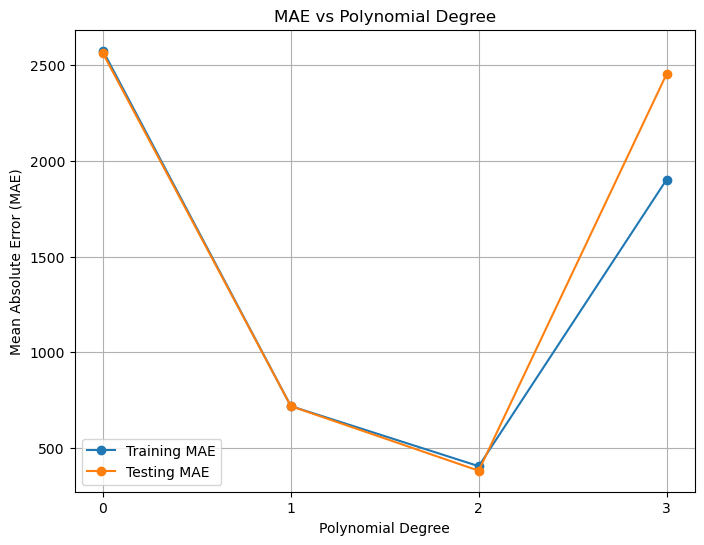

In [5]:
trn_mae = []
tst_mae = []
degrees = range(4)

for i in degrees:
    
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(X_train)
    X_poly_test = poly.fit_transform(X_test)
    model = LinearRegression()
    kf = KFold(n_splits=10, shuffle=True, random_state=42)  
    mae_scores = cross_val_score(model, X_poly, y_train, cv=kf, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores  
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    print(f'Mean MAE: {mean_mae}')
    print(f'Standard Deviation of MAE: {std_mae}')
    trn_mae.append(mean_mae)
    
    model = LinearRegression()
    model.fit(X_poly, y_train)
    y_pred = model.predict(X_poly_test)
    mae = mean_absolute_error(y_test, y_pred)
    tst_mae.append(mae)
    
# Plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, trn_mae, label='Training MAE', marker='o')
plt.plot(degrees, tst_mae, label='Testing MAE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.xticks(degrees)  # Ensure all polynomial degrees are shown on the x-axis
plt.show()

In [6]:
### Polynomial Regression
### ----------------------------------------------------------------------------
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

# Cross validation procedure
model = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 5 fold CV
mse_scores = cross_val_score(model, X_poly, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

# model fit on testing data
model = LinearRegression()
model.fit(X_poly, y_train)
joblib.dump(model, 'polynomial_regression_model.joblib')
y_pred = model.predict(X_poly_test)

mae = np.mean(abs(y_pred - y_test))
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print("R-squared:", r_squared)
print("Mean Squared Error:", mse)

Mean MSE: 20055852.51382705
Standard Deviation of MSE: 58290599.6648237
MAE: 381.45554031864395
R-squared: 0.9581942935041974
Mean Squared Error: 459504.63060316234


In [7]:
import warnings
warnings.filterwarnings("ignore")

### SHOW TRAINING EXAMPLES FOR EACH
print(df[:1]) # dataset row
print(y[1])
x1 = df[:1]
x1 = scaler.transform(x1)
X_poly = poly.fit_transform(x1)

#print(model1.predict(x1)) # regression output
print(model.predict(X_poly)) # polynomial output
#print(rf_regressor_best.predict(x1)) # random forest output
#print(best_xgb_model.predict(x1)) # xgboost output
#print(model3.predict(x1)) # neural network output 

   carat  depth  table     x     y     z  cut_encoded  color_encoded  \
0   0.23   61.5   55.0  3.95  3.98  2.43            4              5   

   clarity_encoded  
0                1  
326
[290.53666736]


***

#### Decision Trees

In [9]:
### Random Forests
### ----------------------------------------------------------------------------
### grid search
rf = RandomForestRegressor()  

rf_param_grid = {
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)  

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

### model fit on testing data
best_params = {
    'bootstrap': True,
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

rf_regressor_best = RandomForestRegressor(**best_params, random_state=42)
rf_regressor_best.fit(X_train, y_train)
joblib.dump(rf_regressor_best, 'random_forest_regressor_model.joblib')

y_pred = rf_regressor_best.predict(X_test)
mae = np.mean(abs(y_pred - y_test))
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print("R-squared:", r_squared)
print("Mean Squared Error:", mse)

MAE: 228.24693726106415
R-squared: 0.9832718718950355
Mean Squared Error: 183866.10273709544


In [10]:
### XGBoost
### ----------------------------------------------------------------------------
### grid search

xgb_model = xgb.XGBRegressor()  
xgb_param_grid = {
    'max_depth': [3, 6, 9],  
    'learning_rate': [0.1, 0.01],  
    'n_estimators': [100, 200, 300],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1],  
    'reg_alpha': [0, 0.1],  
    'reg_lambda': [0, 0.1]  
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
grid_search_xgb.fit(X_train, y_train)  
print("XGBoost - Best parameters found: ", grid_search_xgb.best_params_)
print("XGBoost - Best negative mean squared error found: ", grid_search_xgb.best_score_)

### model fit on testing data
best_params = best_params = {
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 200,
    'reg_alpha': 0,
    'reg_lambda': 0.1,
    'subsample': 1.0
}

# Train a new model with the best parameters on the entire training dataset
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)
joblib.dump(best_xgb_model, 'xgboost_regressor_model.joblib')

# Evaluate the model on the test dataset
y_pred = best_xgb_model.predict(X_test)
mae = np.mean(abs(y_pred - y_test))
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print("R-squared:", r_squared)
print("Mean Squared Error:", mse)

MAE: 223.12396906355298
R-squared: 0.9848142716555814
Mean Squared Error: 166912.9187911848


***

#### Neural Network

In [7]:
### Defining the Neural Network ------------------------------------------------
def create_model(num_neurons = 64, dropout_rate=0.0, optimizer='adam', learning_rate = 0.01):
    model = Sequential()
    # hidden layer
    model.add(Dense(num_neurons, input_dim=9, activation='relu'))  
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(1, activation='relu'))
    
    # optimizer
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    else:
        raise ValueError('optimizer {} unrecognized'.format(optimizer))
        
    # compile
    model.compile(optimizer = opt, 
                loss = 'mean_squared_error', 
                metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

### Implement Grid Search -------------------------------------------------------
ann = KerasRegressor(build_fn=create_model, verbose=0)

# these are the values for the other hyperparameters
param_grid = dict(
    num_neurons= [16, 32, 64],
    dropout_rate= [0, 0.2, 0.5],
    optimizer = ['rmsprop', 'adam', 'SGD'],
    batch_size = [256, 512, 1024],
    learning_rate = [0.001, 0.01, 0.1]
)

# apply 5-fold CV to grid search
grid = GridSearchCV(estimator=ann, cv=5, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

# print best set of parameters // comes after the warnings 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/var/folders/61/4f_9vd3x7c9_5dsr15qd4fww0000gn/T/ipykernel_63018/290867378.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann = KerasRegressor(build_fn=create_model, verbose=0)


Best: -765697.262500 using {'batch_size': 256, 'dropout_rate': 0, 'learning_rate': 0.1, 'num_neurons': 64, 'optimizer': 'rmsprop'}


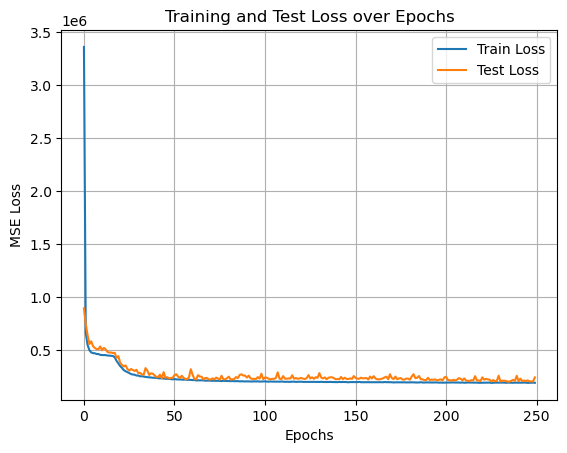

In [31]:
# Extract the best parameters from grid search
best_params = grid_result.best_params_

best_num_neurons = best_params['num_neurons']
best_dropout_rate = best_params['dropout_rate']
best_optimizer = best_params['optimizer']
best_batch = best_params['batch_size']
best_learning_rate = best_params['learning_rate']


# Train the final model with the best parameters and plot the MSE loss
# 100 epochs
final_model = create_model(num_neurons = best_num_neurons, 
                           dropout_rate= best_dropout_rate, 
                           optimizer= best_optimizer, 
                           learning_rate = best_learning_rate)
    
    
history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=250, batch_size=best_batch, verbose=0)

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Test Loss over Epochs')
plt.grid()
plt.show()

In [6]:
model = keras.Sequential([
    layers.Input(shape=(9,)),  
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='relu')  
])


model.compile(optimizer='rmsprop',  
              loss='mean_squared_error', 
              metrics=['mae'])

learning_rate = 0.1  
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.1)

model.compile(optimizer=optimizer,  
              loss='mean_squared_error', 
              metrics=['mae'])

model.fit(X_train, y_train, epochs=250, batch_size=256, validation_split=0.2, verbose = 0)
y_pred = model.predict(X_test)

model.save_weights("model_weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
y_pred = y_pred.reshape(-1,)
mae = np.mean(abs(y_pred - y_test))
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}')
print("R-squared:", r_squared)
print("Mean Squared Error:", mse)

405/405 [==============================] - 0s 357us/step
MAE: 310.94704295534274
R-squared: 0.9340902921522563
Mean Squared Error: 724442.1514747186
